# Housing Insecurity Project: Predicting High Eviction Rates with Deep Learning

Written by Laura Prichard, 12 February 2022

**Objectives**

- Use data on housing loss to find factors that can reduce housing insecurity. 
- Explore factors affecting eviction rates and use deep learning to predict areas with higher than average eviction rates. 
- Model can be used to easily identify areas that may have higher than average eviction rates so additional resources can be allocated to reduce housing loss.

**Data Used**

- From the [DataKind Data Dive](https://datadive.datakind.org/), Housing Insecurity Project, 18 September 2021
- [**Housing Insecurity Project**](https://docs.google.com/document/d/1ovSvMK39wO6NXqCrH0chQL7aRHR6Lr0vQIzXhmUEBFk/edit) | [Project GitHub](https://github.com/datakind/sep21-housing-insecurity) | [Tasks](https://docs.google.com/spreadsheets/d/1H4KZ31jKkhyBYXAlYm_Bw-RjTNkVoeskye0GwtbPuvM/edit?pli=1#gid=0) | [Data Folder](https://drive.google.com/drive/folders/19B0xzeRyozYJDxwXKlGIPFe3Qnc3nfux)
- Previously performed Exploratory Data Analysis on the National Housing Preservation Database (NHPD)
- Some data cleaning to homogenize column formats and variables, already complete. Code from others to combine data from different sources. Combined in [HousingInsecurity_RentPredictionModel.ipynb](https://github.com/lprichard/machine_learning/blob/main/HousingInsecurity_RentPredictionModel.ipynb).
- Previous modeling and analysis on eviction rates with supervised and unsupervised ML in [HousingInsecurity_EvictionRateModel.ipynb](https://github.com/lprichard/machine_learning/blob/main/HousingInsecurity_EvictionRateModel.ipynb) and [HousingInsecurity_EvictionRateClustering.ipynb](https://github.com/lprichard/machine_learning/blob/main/HousingInsecurity_EvictionRateClustering.ipynb).

**Skills**
- Data Cleaning
- Exploratory Data Analysis
- Feature Engineering
- Testing of Feature Importance
- Predictive Modeling
- Hyperparameter Tuning
- Supervised Models
    - Random Forest Classifier
    - Linear Regression
- Unsupervised Methods
    - K-Means Clustering
- Deep Learning Models
    - Constructing Neural Nets
    - Testing Activation Functions
- Metrics
    - ROC-AUC Curves
    - Loss Functions
    - Accuracy
- Cross Validation

**Overview**

This investigation aimed to predict areas with higher than average eviction rates in social housing based on demographic information of the areas using deep learning models. These prediction models could be used to identify areas where the eviction rate has historically been shown to be higher than average so that additional policy and resources can be put in place to prevent housing loss.

The American Community Survey (ACS) data were cleaned ready for analysis resulting in 856 entries. Data exploration was used to identify the 10 most important features for predicting the target variable ('avg-eviction-rate'). The target variable was transformed to a binary value of above average eviction rates to be used for classification.

Four deep learning models were tested:

- MODEL 1: Neural Net with Single Hidden Layer (Sigmoid Activation)
- MODEL 2: Neural Net with Two Hidden Layers (ReLU Activation)
- MODEL 3: Neural Net with Three Hidden Layers (Mixed Activation Functions)
- MODEL 4: Neural Net (Two Hidden Layers, ReLU Activation) & K-Means Clustering

The different models were cross validated by measuring their performance compared to a baseline Random Forest classifier and measuring the accuracy score. Model 2 returned the highest accuracy score and was deemed the best fitting model and easiest to interpret and apply to the data for other users. 

Many features in the database have no correlation to the average eviction rate. Work was done to identify the best features for prediction with some correlation with the target variable. These features are likely to have root underlying causes. Ultimately areas with these key demographic trends should be targeted for the most housing assistance to prevent evictions. 

**Conclusions**

**Recommending MODEL 2: Neural Net with Two Hidden Layers (ReLU activation)** for predicting higher than average eviction rates.  

**Next Steps**

- Accuracy score of 0.7588 is reasonable given the stochastic nature of the real-world data. Perhaps there are features not included in the database that could have better correlation with the target variable, such as poverty rates. 
- For deep learning, very large samples (at least 1000 and ideally >10,000) should be used. The data available were limited as this analysis is based on only three counties worth of data in Florida.
- Expanding this analysis to more counties would improve models and be interesting to see how the relation between these predictive metrics and the target variables varies by area across the US.

In [1]:
import os
import copy
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, r2_score

from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models  import Sequential

pd.options.display.max_rows = 150

# Load data, test feature importance

In [2]:
# Set data directory
data_root = "/Users/lprichard/Dropbox/Data_Science/DataKind_18Sep21/"
os.chdir(data_root)

# Load in housing loss data from NHPD
housing_loss=pd.concat([pd.read_csv('./data/hills_loss.csv'),
                       pd.read_csv('./data/miami_loss.csv'),
                       pd.read_csv('./data/orange_loss.csv')])

# Set target variable
tcol = 'avg-eviction-rate'

# Make a copy of table for analysis, dropping NaNs in key columns
data_in = copy.deepcopy(housing_loss.dropna(subset=[tcol, 'pct-without-health-insurance']).reset_index(drop=True)) #copy.deepcopy(housing_loss.dropna(subset=[tcol, 'pct-without-health-insurance']))
data_in

,census_tract_GEOID,total-households,total-renter-occupied-households,total-owner-occupied-households,total-owner-occupied-households-mortgage,median-gross-rent,median-household-income,median-property-value,median-monthly-housing-cost,pct-white,...,lien-foreclosure-rate-2019,avg-eviction-rate,ratio-to-mean-foreclosure-rate,ratio-to-mean-eviction-rate,avg-housing-loss-rate,evictions-pct-total-housing-loss,housing-loss-index,county_GEOID,county,state
0,12057000401,926,338,588,432,1055,48426,148200,1172,669,...,NaN,4.879664,0.655993,2.154130,2.401723,0.891853,1.583222,12057,Hillsborough County,Florida
1,12057010105,1496,381,1115,653,879,53860,232000,1549,1431,...,0.000000,1.612298,1.012621,0.711750,1.045408,0.568282,0.689136,12057,Hillsborough County,Florida
2,12057010203,766,395,371,197,846,39018,96500,1155,524,...,0.269542,5.080382,2.877047,2.242737,4.065458,0.833801,2.679961,12057,Hillsborough County,Florida
3,12057010600,1108,354,754,481,1095,80600,234300,1584,817,...,NaN,10.003766,0.785556,4.416168,4.560479,0.929972,3.006280,12057,Hillsborough County,Florida
4,12057002300,1419,599,820,592,1138,62636,212600,1400,1159,...,0.000000,0.962565,1.037179,0.424925,0.847951,0.570919,0.558972,12057,Hillsborough County,Florida
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,12095014906,2357,649,1708,1098,1467,64710,214100,1580,1476,...,0.058548,2.213465,0.648098,0.698493,1.394699,0.589582,0.592379,12095,Orange County,Florida
1007,12095015202,2365,1327,1038,683,965,39132,163300,1303,1390,...,0.289017,2.989320,1.632296,0.943326,2.752982,0.716876,1.169291,12095,Orange County,Florida
1008,12095015402,1069,538,531,299,1303,53958,291700,1253,963,...,0.188324,1.345863,0.832990,0.424708,1.283243,0.674138,0.545040,12095,Orange County,Florida
1009,12095015501,1989,949,1040,569,1377,63994,289300,1729,1736,...,0.000000,1.545012,1.125572,0.487552,1.558772,0.619646,0.662067,12095,Orange County,Florida


In [3]:
# Count NaNs in columns to identify those to drop
data_in.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 73 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract_GEOID                        1011 non-null   int64  
 1   total-households                          1011 non-null   int64  
 2   total-renter-occupied-households          1011 non-null   int64  
 3   total-owner-occupied-households           1011 non-null   int64  
 4   total-owner-occupied-households-mortgage  1011 non-null   int64  
 5   median-gross-rent                         1011 non-null   int64  
 6   median-household-income                   1011 non-null   int64  
 7   median-property-value                     1011 non-null   int64  
 8   median-monthly-housing-cost               1011 non-null   int64  
 9   pct-white                                 1011 non-null   int64  
 10  pct-af-am                           

/Users/lprichard/miniconda3/envs/a37_tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


In [4]:
# De-select columns with higher number of NaNs and those with close correlation to target 
# data_in.columns.tolist()
an_cols = [#'census_tract_GEOID',
 'total-households',
 'total-renter-occupied-households',
 'total-owner-occupied-households',
 'total-owner-occupied-households-mortgage',
 'median-gross-rent',
 'median-household-income',
 'median-property-value',
 'median-monthly-housing-cost',
 'pct-white',
 'pct-af-am',
 'pct-hispanic',
 'pct-am-indian',
 'pct-asian',
 'pct-nh-pi',
 'pct-multiple',
 'pct-other',
 'pct-below-poverty-level',
 'households-children',
 'single-parent-household',
 'older-adult-alone',
 'level-of-education',
 'immigrant-status',
 'english-fluency',
 'drive-to-work',
 'public-transport-to-work',
 'vacant-properties',
 'live-in-mobile-home',
 'pct-renter-occupied',
 'pct-owner-occupied',
 'pct-owner-occupied-mortgage',
 'pct-owner-occupied-without-mortgage',
 'median-house-age',
 'pct-non-white',
 'pct-without-health-insurance',
#  'total-evictions',
#  'avg-evictions',
#  'total-foreclosure-sales',
#  'avg-foreclosure-sales',
#  'total-lien-foreclosures',
#  'avg-lien-foreclosures',
#  'total-evictions-2017',
#  'eviction-filings-2017',
#  'eviction-rate-2017',
#  'total-evictions-2018',
#  'eviction-filings-2018',
#  'eviction-rate-2018',
#  'total-evictions-2019',
#  'eviction-filings-2019',
#  'eviction-rate-2019',
#  'foreclosure-sales-2017',
#  'foreclosure-sales-2018',
#  'foreclosure-sales-2019',
#  'lien-foreclosures-2017',
#  'lien-foreclosures-2018',
#  'lien-foreclosures-2019',
#  'avg-foreclosure-rate',
#  'foreclosure-rate-2017',
#  'foreclosure-rate-2018',
#  'foreclosure-rate-2019',
#  'avg-lien-foreclosure-rate',
#  'lien-foreclosure-rate-2017',
#  'lien-foreclosure-rate-2018',
#  'lien-foreclosure-rate-2019',
#  'ratio-to-mean-foreclosure-rate',
#  'ratio-to-mean-eviction-rate',
 'avg-eviction-rate']
#  'avg-housing-loss-rate',
#  'evictions-pct-total-housing-loss',
#  'housing-loss-index',
#  'county_GEOID',
#  'county',
#  'state']

In [5]:
# Check NaN values in down-selected columns
data_in[an_cols].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 35 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   total-households                          1011 non-null   int64  
 1   total-renter-occupied-households          1011 non-null   int64  
 2   total-owner-occupied-households           1011 non-null   int64  
 3   total-owner-occupied-households-mortgage  1011 non-null   int64  
 4   median-gross-rent                         1011 non-null   int64  
 5   median-household-income                   1011 non-null   int64  
 6   median-property-value                     1011 non-null   int64  
 7   median-monthly-housing-cost               1011 non-null   int64  
 8   pct-white                                 1011 non-null   int64  
 9   pct-af-am                                 1011 non-null   int64  
 10  pct-hispanic                        

/Users/lprichard/miniconda3/envs/a37_tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  


In [6]:
# Calculate the correlation values
feature_cols = an_cols
corr_values = data_in[feature_cols].corr()
corr_values

# Empty all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a dataframe
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

In [7]:
# Get all correlations with the target variable and sort for feature importance
corr_values.loc[(corr_values['feature1']==tcol) | (corr_values['feature2']==tcol)].sort_values('abs_correlation', ascending=False)   #['feature1'].to_list()

,feature1,feature2,correlation,abs_correlation
284,pct-af-am,avg-eviction-rate,0.383209,0.383209
307,pct-hispanic,avg-eviction-rate,-0.292620,0.292620
260,pct-white,avg-eviction-rate,-0.282337,0.282337
559,pct-non-white,avg-eviction-rate,0.282337,0.282337
482,immigrant-status,avg-eviction-rate,-0.280359,0.280359
182,median-household-income,avg-eviction-rate,-0.227248,0.227248
560,pct-without-health-insurance,avg-eviction-rate,0.197344,0.197344
494,english-fluency,avg-eviction-rate,0.185981,0.185981
154,median-gross-rent,avg-eviction-rate,-0.158395,0.158395
209,median-property-value,avg-eviction-rate,-0.154900,0.154900


In [8]:
# Set feature cols to model on based on correlation (remove high negative/zero count colummns)
icols = ['pct-af-am',
 'pct-hispanic',
 'pct-white',
 'immigrant-status',
 'median-household-income',
 'pct-without-health-insurance',
 'english-fluency',
 'older-adult-alone',
 'single-parent-household',
 'pct-owner-occupied-without-mortgage']

mcols = icols + [tcol]

In [9]:
# Count zeros/negatives
data_in[mcols].lt(0.00001).sum()

pct-af-am                              70
pct-hispanic                            2
pct-white                               0
immigrant-status                        4
median-household-income                 0
pct-without-health-insurance            2
english-fluency                         0
older-adult-alone                       2
single-parent-household                76
pct-owner-occupied-without-mortgage     9
avg-eviction-rate                       1
dtype: int64

In [10]:
# Create new dataframe with model and target features and no zero/negative values
data = copy.deepcopy(data_in[mcols][(data_in[mcols] > 0).all(1)].dropna().reset_index(drop=True))
data

,pct-af-am,pct-hispanic,pct-white,immigrant-status,median-household-income,pct-without-health-insurance,english-fluency,older-adult-alone,single-parent-household,pct-owner-occupied-without-mortgage,avg-eviction-rate
0,155,207,669,78,48426,12.961567,1805,172,21,16.846652,4.879664
1,8,242,1431,322,53860,13.405495,3130,206,19,30.882353,1.612298
2,212,54,524,49,39018,22.698413,1674,115,28,22.715405,5.080382
3,225,186,817,321,80600,9.465021,2342,136,19,24.638989,10.003766
4,184,179,1159,159,62636,10.792476,2794,223,46,16.067653,0.962565
...,...,...,...,...,...,...,...,...,...,...,...
851,495,399,1611,1352,76203,10.587372,3707,354,14,14.897053,1.116809
852,504,515,1476,1085,64710,10.587895,4232,185,11,25.880356,2.213465
853,709,544,1390,479,39132,22.700777,4893,435,79,15.010571,2.989320
854,31,248,963,95,53958,6.620047,1582,220,64,21.702526,1.345863


In [11]:
# Define new binary target variable  for classification
data['abv-avg-eviction-rate'] = (data['avg-eviction-rate'] >= data['avg-eviction-rate'].median()).astype(np.int64)
data

,pct-af-am,pct-hispanic,pct-white,immigrant-status,median-household-income,pct-without-health-insurance,english-fluency,older-adult-alone,single-parent-household,pct-owner-occupied-without-mortgage,avg-eviction-rate,abv-avg-eviction-rate
0,155,207,669,78,48426,12.961567,1805,172,21,16.846652,4.879664,1
1,8,242,1431,322,53860,13.405495,3130,206,19,30.882353,1.612298,0
2,212,54,524,49,39018,22.698413,1674,115,28,22.715405,5.080382,1
3,225,186,817,321,80600,9.465021,2342,136,19,24.638989,10.003766,1
4,184,179,1159,159,62636,10.792476,2794,223,46,16.067653,0.962565,0
...,...,...,...,...,...,...,...,...,...,...,...,...
851,495,399,1611,1352,76203,10.587372,3707,354,14,14.897053,1.116809,0
852,504,515,1476,1085,64710,10.587895,4232,185,11,25.880356,2.213465,1
853,709,544,1390,479,39132,22.700777,4893,435,79,15.010571,2.989320,1
854,31,248,963,95,53958,6.620047,1582,220,64,21.702526,1.345863,0


In [12]:
data['avg-eviction-rate'].mean()

inf

In [13]:
data.describe()

,pct-af-am,pct-hispanic,pct-white,immigrant-status,median-household-income,pct-without-health-insurance,english-fluency,older-adult-alone,single-parent-household,pct-owner-occupied-without-mortgage,avg-eviction-rate,abv-avg-eviction-rate
count,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.00000,856.000000,856.000000,856.000000
mean,339.723131,816.797897,1362.102804,1055.531542,58381.464953,15.380165,2451.106308,272.800234,57.44743,19.738550,inf,0.500000
std,419.231839,674.025987,841.876985,923.701707,27255.065922,7.759748,2141.561745,182.135862,52.56432,10.381071,NaN,0.500292
min,1.000000,6.000000,18.000000,14.000000,14848.000000,0.771076,45.000000,19.000000,4.00000,0.168919,0.087873,0.000000
25%,53.750000,299.750000,826.750000,334.000000,38551.500000,9.464754,980.750000,145.000000,22.00000,11.952263,0.935925,0.000000
50%,167.500000,590.500000,1284.000000,799.500000,52698.000000,14.609301,2103.000000,230.000000,44.00000,18.979210,1.750882,0.500000
75%,448.000000,1194.750000,1759.000000,1490.000000,72514.000000,20.611440,3367.750000,352.000000,72.00000,25.533490,2.784617,1.000000
max,2565.000000,5001.000000,8072.000000,5679.000000,250001.000000,44.164760,21237.000000,1269.000000,465.00000,67.514793,inf,1.000000


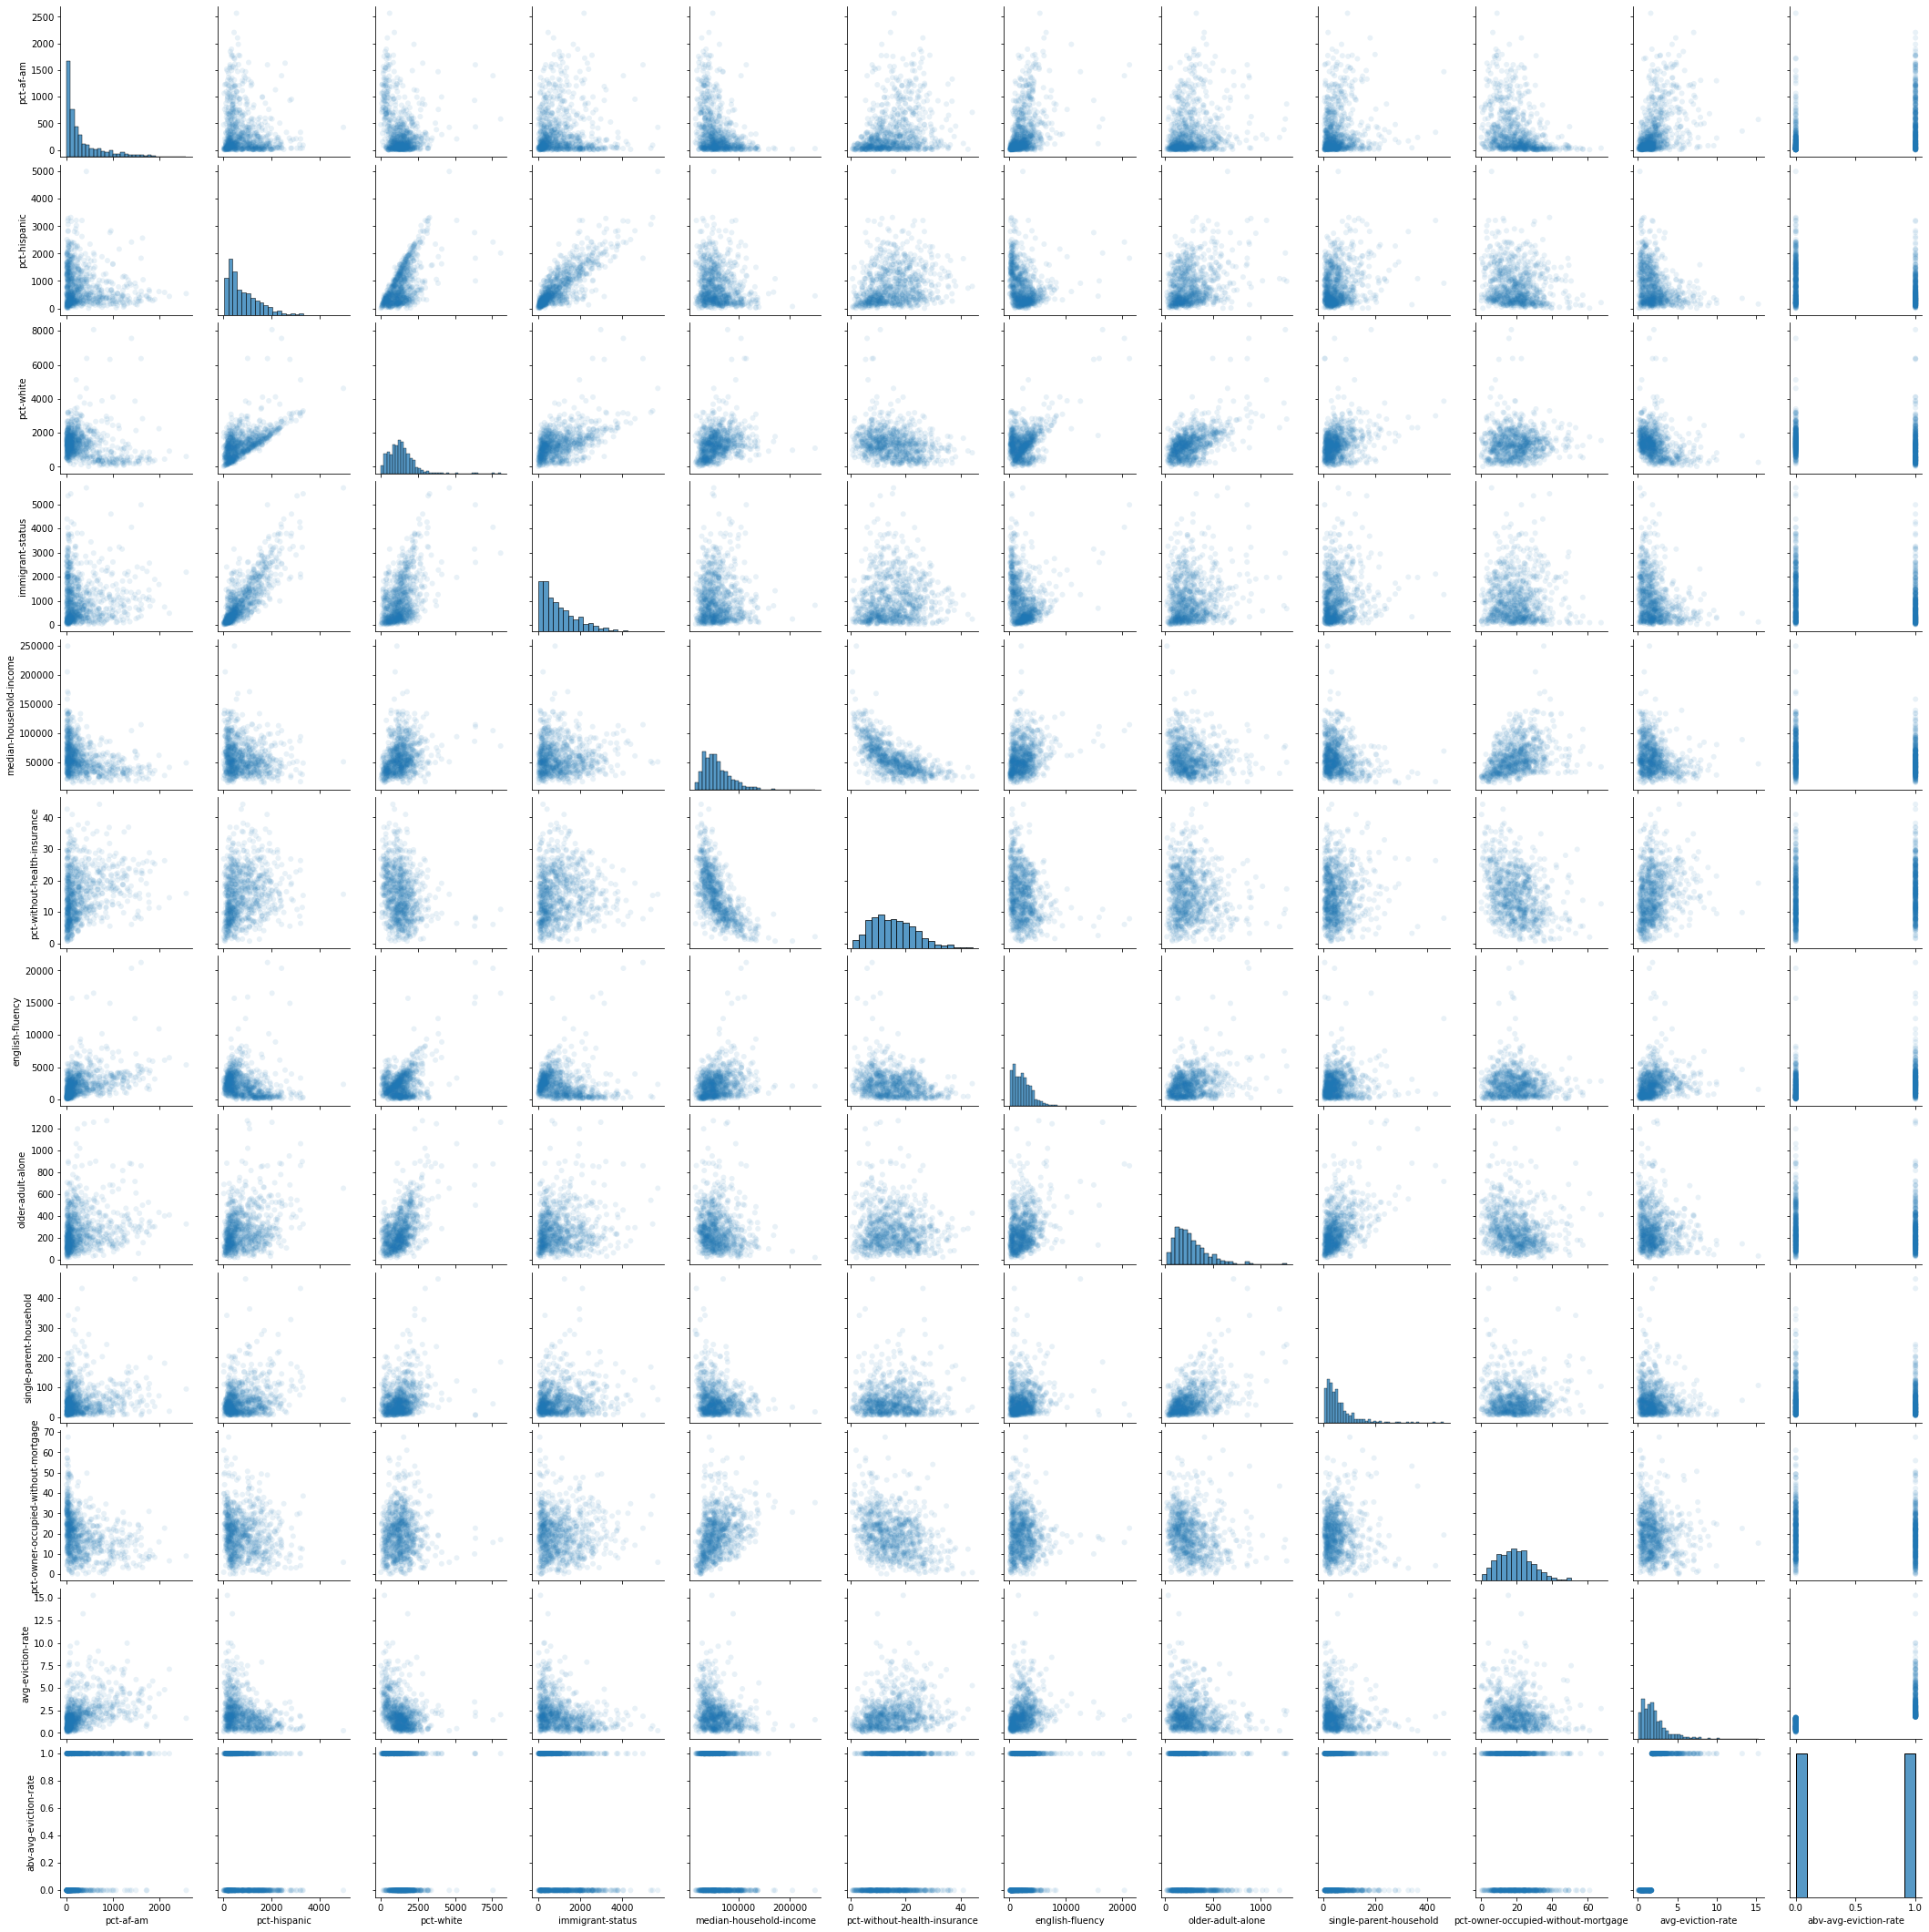

In [14]:
# Compare feature relations
sns.pairplot(data, plot_kws=dict(alpha=.1, edgecolor='none'))

# Testing Linear Regression

In [15]:
# Define model
lr = LinearRegression()

# Define data sets
y_col = tcol

X = data[icols]
y = data[y_col]

In [16]:
# Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)

In [17]:
# Scale the training data
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

In [18]:
# Log transform the target variable, replace one inf value
y_train_log = np.log1p(y_train)
y_train_l = np.array(y_train_log.replace(np.inf, -1))

In [19]:
# Run linear regression on transformed data
lr.fit(X_train_s, y_train_l)
X_test_s = s.transform(X_test)
y_pred_l = lr.predict(X_test_s)

In [20]:
# Determine R2 score
y_pred_tran = np.expm1(y_pred_l)
r2_score(y_pred_tran,y_test)

-1.0772006260815248

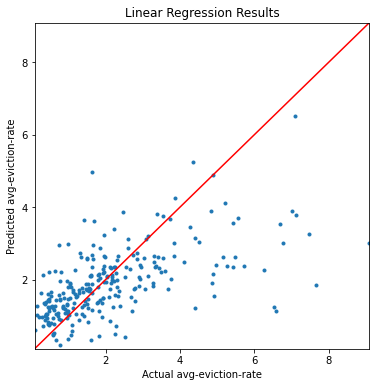

In [21]:
# Compare actual vs predicted values
f = plt.figure(figsize=(6,6))
ax = plt.axes()

# Plot the test data and predictions
ax.plot(y_test, y_pred_tran, 
         marker='o', ls='', ms=3.0)

xvals = np.linspace(y_test.min(), y_test.max(),100)
plt.plot(xvals, xvals, '-r')

lim = (y_test.min(), y_test.max())

ax.set(xlabel='Actual {}'.format(tcol), 
       ylabel='Predicted {}'.format(tcol), 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

# Use RandomForest Model to Get Baseline

In [22]:
# Set data arrays as discrete version of target variable
X = data[icols]
y_c = data['abv-avg-eviction-rate']

# Split data into test and training sets using classification variable
X_train, X_test, y_train_c, y_test_c = train_test_split(X, y_c, test_size=0.3, random_state=72018)

In [23]:
# Get split of data set (50/50 by design)
np.mean(y_c), np.mean(1-y_c)

(0.5, 0.5)

In [24]:
# Train the RandomForest model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train_c)

RandomForestClassifier(n_estimators=200)

In [25]:
# Make predictions on the test set
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

# Determine stats
print('accuracy is {:.3f}'.format(accuracy_score(y_test_c,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test_c,y_pred_prob_rf[:,1])))

accuracy is 0.708
roc-auc is 0.801


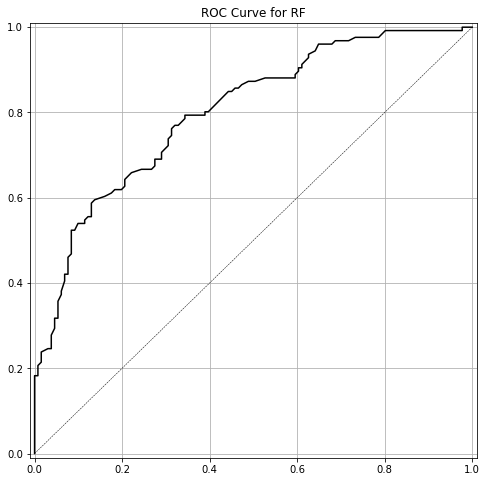

In [26]:
# Plot the ROC curve
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {}'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

plot_roc(y_test_c, y_pred_prob_rf[:, 1], 'RF')

# Single Layer Neural Net with Hidden Layer

In [27]:
# Normalize the data
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

In [28]:
# Define the Model: Input size is 10 dimensions, 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(12, input_shape =(10,) ,activation='sigmoid'))
model_1.add(Dense(1, activation='sigmoid'))

In [29]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                132       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Run the model and get metrics
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_s, y_train_c, validation_data=(X_test_s, y_test_c), epochs=500)

Epoch 1/500


/Users/lprichard/miniconda3/envs/a37_tf/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 0s 9ms/step - loss: 0.7693 - accuracy: 0.4958 - val_loss: 0.7591 - val_accuracy: 0.5175
Epoch 2/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7629 - accuracy: 0.4958 - val_loss: 0.7533 - val_accuracy: 0.5292
Epoch 3/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7571 - accuracy: 0.4942 - val_loss: 0.7480 - val_accuracy: 0.5292
Epoch 4/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7518 - accuracy: 0.4908 - val_loss: 0.7432 - val_accuracy: 0.5292
Epoch 5/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7470 - accuracy: 0.4908 - val_loss: 0.7389 - val_accuracy: 0.5292
Epoch 6/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7426 - accuracy: 0.4891 - val_loss: 0.7350 - val_accuracy: 0.5292
Epoch 7/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7387 - accuracy: 0.4908 - val_loss: 0.7315 - val_accuracy: 0.5292
Epoch 8/500
19/19 [======

Epoch 59/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6826 - accuracy: 0.5993 - val_loss: 0.6824 - val_accuracy: 0.5681
Epoch 60/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.6043 - val_loss: 0.6820 - val_accuracy: 0.5681
Epoch 61/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.6110 - val_loss: 0.6815 - val_accuracy: 0.5798
Epoch 62/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.6144 - val_loss: 0.6811 - val_accuracy: 0.5798
Epoch 63/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.6177 - val_loss: 0.6806 - val_accuracy: 0.5914
Epoch 64/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6802 - accuracy: 0.6194 - val_loss: 0.6802 - val_accuracy: 0.5914
Epoch 65/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.6210 - val_loss: 0.6798 - val_accuracy: 0.5953
Epoch 

19/19 [==============================] - 0s 2ms/step - loss: 0.6335 - accuracy: 0.7095 - val_loss: 0.6391 - val_accuracy: 0.7004
Epoch 174/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6331 - accuracy: 0.7078 - val_loss: 0.6387 - val_accuracy: 0.7004
Epoch 175/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6328 - accuracy: 0.7095 - val_loss: 0.6384 - val_accuracy: 0.7043
Epoch 176/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6324 - accuracy: 0.7112 - val_loss: 0.6380 - val_accuracy: 0.7043
Epoch 177/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6319 - accuracy: 0.7095 - val_loss: 0.6377 - val_accuracy: 0.7043
Epoch 178/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.7095 - val_loss: 0.6374 - val_accuracy: 0.7043
Epoch 179/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6312 - accuracy: 0.7095 - val_loss: 0.6370 - val_accuracy: 0.7043
Epoch 180/500

19/19 [==============================] - 0s 2ms/step - loss: 0.5923 - accuracy: 0.7229 - val_loss: 0.6049 - val_accuracy: 0.7082
Epoch 288/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5920 - accuracy: 0.7245 - val_loss: 0.6046 - val_accuracy: 0.7082
Epoch 289/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5917 - accuracy: 0.7229 - val_loss: 0.6044 - val_accuracy: 0.7082
Epoch 290/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5914 - accuracy: 0.7245 - val_loss: 0.6041 - val_accuracy: 0.7082
Epoch 291/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.7245 - val_loss: 0.6039 - val_accuracy: 0.7082
Epoch 292/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.7262 - val_loss: 0.6036 - val_accuracy: 0.7082
Epoch 293/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7262 - val_loss: 0.6034 - val_accuracy: 0.7082
Epoch 294/500

19/19 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.7396 - val_loss: 0.5814 - val_accuracy: 0.7121
Epoch 402/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5612 - accuracy: 0.7396 - val_loss: 0.5812 - val_accuracy: 0.7121
Epoch 403/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7379 - val_loss: 0.5811 - val_accuracy: 0.7121
Epoch 404/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.7379 - val_loss: 0.5809 - val_accuracy: 0.7121
Epoch 405/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5606 - accuracy: 0.7379 - val_loss: 0.5808 - val_accuracy: 0.7121
Epoch 406/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5603 - accuracy: 0.7379 - val_loss: 0.5806 - val_accuracy: 0.7121
Epoch 407/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5601 - accuracy: 0.7379 - val_loss: 0.5805 - val_accuracy: 0.7121
Epoch 408/500

In [31]:
# Calculate predictions
predict_x=model_1.predict(X_test_s) 
y_pred_class_nn_1=np.argmax(predict_x,axis=1)

y_pred_prob_nn_1 = model_1.predict(X_test_s)

accuracy is 0.510
roc-auc is 0.787


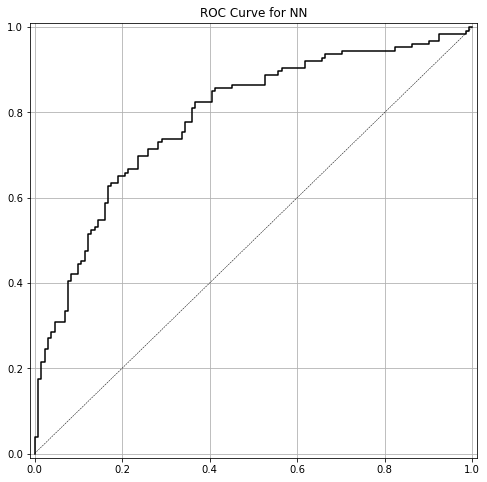

In [32]:
# Get model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test_c,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test_c,y_pred_prob_nn_1)))

plot_roc(y_test_c, y_pred_prob_nn_1, 'NN')

**Test best number of epochs**

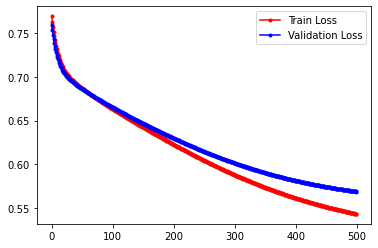

In [33]:
# Check loss values
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [34]:
# Continue fitting (picks up where it left off)
run_hist_1b = model_1.fit(X_train_s, y_train_c, validation_data=(X_test_s, y_test_c), epochs=1000)

Epoch 1/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.5432 - accuracy: 0.7462 - val_loss: 0.5689 - val_accuracy: 0.7237
Epoch 2/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5431 - accuracy: 0.7462 - val_loss: 0.5688 - val_accuracy: 0.7237
Epoch 3/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.7462 - val_loss: 0.5687 - val_accuracy: 0.7237
Epoch 4/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5428 - accuracy: 0.7462 - val_loss: 0.5686 - val_accuracy: 0.7198
Epoch 5/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5427 - accuracy: 0.7479 - val_loss: 0.5685 - val_accuracy: 0.7198
Epoch 6/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.7479 - val_loss: 0.5684 - val_accuracy: 0.7198
Epoch 7/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5424 - accuracy: 0.7479 - val_loss: 0.5683 - val_accuracy: 0.7198
Epoch 

19/19 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.7546 - val_loss: 0.5608 - val_accuracy: 0.7276
Epoch 116/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5300 - accuracy: 0.7563 - val_loss: 0.5608 - val_accuracy: 0.7276
Epoch 117/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5298 - accuracy: 0.7546 - val_loss: 0.5607 - val_accuracy: 0.7276
Epoch 118/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.7563 - val_loss: 0.5607 - val_accuracy: 0.7276
Epoch 119/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.7563 - val_loss: 0.5606 - val_accuracy: 0.7276
Epoch 120/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5296 - accuracy: 0.7563 - val_loss: 0.5606 - val_accuracy: 0.7276
Epoch 121/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5295 - accuracy: 0.7546 - val_loss: 0.5605 - val_accuracy: 0.7276
Epoch 1

Epoch 172/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 0.7563 - val_loss: 0.5584 - val_accuracy: 0.7315
Epoch 173/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 0.7563 - val_loss: 0.5583 - val_accuracy: 0.7315
Epoch 174/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5253 - accuracy: 0.7563 - val_loss: 0.5583 - val_accuracy: 0.7315
Epoch 175/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5252 - accuracy: 0.7563 - val_loss: 0.5582 - val_accuracy: 0.7315
Epoch 176/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5251 - accuracy: 0.7563 - val_loss: 0.5582 - val_accuracy: 0.7315
Epoch 177/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5251 - accuracy: 0.7563 - val_loss: 0.5582 - val_accuracy: 0.7315
Epoch 178/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.7563 - val_loss: 0.5581 - val_accuracy:

Epoch 229/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5218 - accuracy: 0.7563 - val_loss: 0.5565 - val_accuracy: 0.7315
Epoch 230/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.7563 - val_loss: 0.5565 - val_accuracy: 0.7315
Epoch 231/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.7563 - val_loss: 0.5565 - val_accuracy: 0.7315
Epoch 232/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5216 - accuracy: 0.7579 - val_loss: 0.5564 - val_accuracy: 0.7315
Epoch 233/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7579 - val_loss: 0.5564 - val_accuracy: 0.7315
Epoch 234/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7579 - val_loss: 0.5564 - val_accuracy: 0.7315
Epoch 235/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5214 - accuracy: 0.7579 - val_loss: 0.5564 - val_accuracy:

Epoch 286/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5189 - accuracy: 0.7563 - val_loss: 0.5552 - val_accuracy: 0.7315
Epoch 287/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.7579 - val_loss: 0.5552 - val_accuracy: 0.7315
Epoch 288/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.7596 - val_loss: 0.5552 - val_accuracy: 0.7315
Epoch 289/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7579 - val_loss: 0.5551 - val_accuracy: 0.7315
Epoch 290/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7596 - val_loss: 0.5551 - val_accuracy: 0.7315
Epoch 291/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5186 - accuracy: 0.7596 - val_loss: 0.5551 - val_accuracy: 0.7315
Epoch 292/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5186 - accuracy: 0.7596 - val_loss: 0.5551 - val_accuracy:

Epoch 343/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.7579 - val_loss: 0.5542 - val_accuracy: 0.7354
Epoch 344/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5164 - accuracy: 0.7579 - val_loss: 0.5542 - val_accuracy: 0.7354
Epoch 345/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5164 - accuracy: 0.7579 - val_loss: 0.5541 - val_accuracy: 0.7354
Epoch 346/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5164 - accuracy: 0.7579 - val_loss: 0.5541 - val_accuracy: 0.7354
Epoch 347/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.7579 - val_loss: 0.5541 - val_accuracy: 0.7354
Epoch 348/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.7579 - val_loss: 0.5541 - val_accuracy: 0.7354
Epoch 349/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5163 - accuracy: 0.7579 - val_loss: 0.5541 - val_accuracy:

Epoch 400/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5146 - accuracy: 0.7563 - val_loss: 0.5535 - val_accuracy: 0.7354
Epoch 401/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5145 - accuracy: 0.7563 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 402/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.5145 - accuracy: 0.7563 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 403/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.5145 - accuracy: 0.7563 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 404/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.5144 - accuracy: 0.7563 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 405/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5144 - accuracy: 0.7563 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 406/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5144 - accuracy: 0.7579 - val_loss: 0.5534 - val_accuracy:

Epoch 457/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5130 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy: 0.7354
Epoch 458/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy: 0.7354
Epoch 459/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy: 0.7354
Epoch 460/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy: 0.7354
Epoch 461/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5128 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy: 0.7354
Epoch 462/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5128 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy: 0.7354
Epoch 463/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5128 - accuracy: 0.7613 - val_loss: 0.5529 - val_accuracy:

Epoch 514/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.7596 - val_loss: 0.5525 - val_accuracy: 0.7393
Epoch 515/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.7629 - val_loss: 0.5525 - val_accuracy: 0.7393
Epoch 516/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.7596 - val_loss: 0.5525 - val_accuracy: 0.7393
Epoch 517/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.7596 - val_loss: 0.5525 - val_accuracy: 0.7393
Epoch 518/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.7596 - val_loss: 0.5525 - val_accuracy: 0.7393
Epoch 519/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.7613 - val_loss: 0.5525 - val_accuracy: 0.7393
Epoch 520/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.7613 - val_loss: 0.5525 - val_accuracy:

Epoch 571/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7579 - val_loss: 0.5523 - val_accuracy: 0.7393
Epoch 572/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7579 - val_loss: 0.5523 - val_accuracy: 0.7393
Epoch 573/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7579 - val_loss: 0.5523 - val_accuracy: 0.7393
Epoch 574/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7579 - val_loss: 0.5523 - val_accuracy: 0.7393
Epoch 575/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7579 - val_loss: 0.5523 - val_accuracy: 0.7393
Epoch 576/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7579 - val_loss: 0.5522 - val_accuracy: 0.7393
Epoch 577/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5103 - accuracy: 0.7596 - val_loss: 0.5522 - val_accuracy:

Epoch 628/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7596 - val_loss: 0.5520 - val_accuracy: 0.7393
Epoch 629/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7596 - val_loss: 0.5520 - val_accuracy: 0.7393
Epoch 630/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7596 - val_loss: 0.5520 - val_accuracy: 0.7393
Epoch 631/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7596 - val_loss: 0.5520 - val_accuracy: 0.7393
Epoch 632/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7596 - val_loss: 0.5520 - val_accuracy: 0.7393
Epoch 633/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7613 - val_loss: 0.5520 - val_accuracy: 0.7393
Epoch 634/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.7613 - val_loss: 0.5520 - val_accuracy:

Epoch 685/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5086 - accuracy: 0.7579 - val_loss: 0.5519 - val_accuracy: 0.7393
Epoch 686/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7579 - val_loss: 0.5519 - val_accuracy: 0.7393
Epoch 687/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5086 - accuracy: 0.7579 - val_loss: 0.5519 - val_accuracy: 0.7393
Epoch 688/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7579 - val_loss: 0.5519 - val_accuracy: 0.7393
Epoch 689/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7579 - val_loss: 0.5518 - val_accuracy: 0.7393
Epoch 690/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7579 - val_loss: 0.5518 - val_accuracy: 0.7393
Epoch 691/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7579 - val_loss: 0.5518 - val_accuracy:

Epoch 742/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy: 0.7393
Epoch 743/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy: 0.7393
Epoch 744/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy: 0.7393
Epoch 745/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy: 0.7393
Epoch 746/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy: 0.7393
Epoch 747/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy: 0.7393
Epoch 748/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.7579 - val_loss: 0.5517 - val_accuracy:

Epoch 799/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7393
Epoch 800/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7393
Epoch 801/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7393
Epoch 802/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 803/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 804/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 805/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5070 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy:

Epoch 856/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 857/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7596 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 858/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 859/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 860/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5065 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 861/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy: 0.7432
Epoch 862/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5064 - accuracy: 0.7613 - val_loss: 0.5515 - val_accuracy:

Epoch 913/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7646 - val_loss: 0.5514 - val_accuracy: 0.7432
Epoch 914/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7646 - val_loss: 0.5514 - val_accuracy: 0.7432
Epoch 915/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7629 - val_loss: 0.5514 - val_accuracy: 0.7432
Epoch 916/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7646 - val_loss: 0.5514 - val_accuracy: 0.7432
Epoch 917/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7646 - val_loss: 0.5514 - val_accuracy: 0.7432
Epoch 918/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5059 - accuracy: 0.7646 - val_loss: 0.5514 - val_accuracy: 0.7432
Epoch 919/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5058 - accuracy: 0.7646 - val_loss: 0.5514 - val_accuracy:

Epoch 970/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.7646 - val_loss: 0.5513 - val_accuracy: 0.7393
Epoch 971/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.7646 - val_loss: 0.5513 - val_accuracy: 0.7393
Epoch 972/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.7646 - val_loss: 0.5513 - val_accuracy: 0.7393
Epoch 973/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.7663 - val_loss: 0.5513 - val_accuracy: 0.7393
Epoch 974/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5054 - accuracy: 0.7646 - val_loss: 0.5513 - val_accuracy: 0.7393
Epoch 975/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7646 - val_loss: 0.5513 - val_accuracy: 0.7393
Epoch 976/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7646 - val_loss: 0.5513 - val_accuracy:

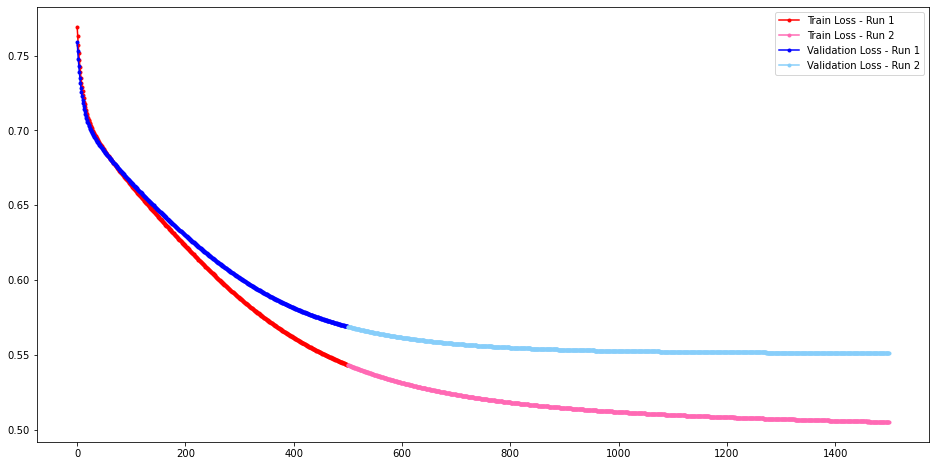

In [35]:
# Plot loss over all fits
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Optimum epochs around **500**

# Model with Two Hidden Layers

In [36]:
# Define model
model_2 = Sequential()
model_2.add(Dense(12, input_shape=(10,), activation="relu"))
model_2.add(Dense(12, activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

# Run model
model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_s, y_train_c, validation_data=(X_test_s, y_test_c), epochs=500)

/Users/lprichard/miniconda3/envs/a37_tf/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
19/19 [==============================] - 0s 7ms/step - loss: 0.7769 - accuracy: 0.4858 - val_loss: 0.7734 - val_accuracy: 0.5214
Epoch 2/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7649 - accuracy: 0.4858 - val_loss: 0.7624 - val_accuracy: 0.5253
Epoch 3/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7544 - accuracy: 0.4908 - val_loss: 0.7525 - val_accuracy: 0.5253
Epoch 4/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7451 - accuracy: 0.5075 - val_loss: 0.7439 - val_accuracy: 0.5253
Epoch 5/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7369 - accuracy: 0.5175 - val_loss: 0.7364 - val_accuracy: 0.5370
Epoch 6/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7296 - accuracy: 0.5309 - val_loss: 0.7296 - val_accuracy: 0.5525
Epoch 7/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.5442 - val_loss: 0.7235 - val_accuracy: 0.5642
Epoch 8/500
1

Epoch 59/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6269 - accuracy: 0.6845 - val_loss: 0.6343 - val_accuracy: 0.6848
Epoch 60/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6260 - accuracy: 0.6845 - val_loss: 0.6335 - val_accuracy: 0.6848
Epoch 61/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6251 - accuracy: 0.6845 - val_loss: 0.6327 - val_accuracy: 0.6848
Epoch 62/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6241 - accuracy: 0.6845 - val_loss: 0.6319 - val_accuracy: 0.6848
Epoch 63/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6232 - accuracy: 0.6861 - val_loss: 0.6310 - val_accuracy: 0.6887
Epoch 64/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6222 - accuracy: 0.6895 - val_loss: 0.6302 - val_accuracy: 0.6887
Epoch 65/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6213 - accuracy: 0.6912 - val_loss: 0.6294 - val_accuracy: 0.6926
Epoch 

19/19 [==============================] - 0s 2ms/step - loss: 0.5534 - accuracy: 0.7162 - val_loss: 0.5693 - val_accuracy: 0.7121
Epoch 174/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.7162 - val_loss: 0.5690 - val_accuracy: 0.7121
Epoch 175/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5527 - accuracy: 0.7179 - val_loss: 0.5687 - val_accuracy: 0.7121
Epoch 176/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7195 - val_loss: 0.5684 - val_accuracy: 0.7121
Epoch 177/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7195 - val_loss: 0.5681 - val_accuracy: 0.7121
Epoch 178/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5516 - accuracy: 0.7179 - val_loss: 0.5678 - val_accuracy: 0.7121
Epoch 179/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7212 - val_loss: 0.5675 - val_accuracy: 0.7121
Epoch 180/500

19/19 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 0.7346 - val_loss: 0.5500 - val_accuracy: 0.7276
Epoch 288/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5252 - accuracy: 0.7346 - val_loss: 0.5499 - val_accuracy: 0.7276
Epoch 289/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.7346 - val_loss: 0.5498 - val_accuracy: 0.7276
Epoch 290/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5249 - accuracy: 0.7379 - val_loss: 0.5497 - val_accuracy: 0.7276
Epoch 291/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5246 - accuracy: 0.7346 - val_loss: 0.5496 - val_accuracy: 0.7276
Epoch 292/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5245 - accuracy: 0.7362 - val_loss: 0.5495 - val_accuracy: 0.7276
Epoch 293/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5243 - accuracy: 0.7362 - val_loss: 0.5494 - val_accuracy: 0.7276
Epoch 294/500

19/19 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.7546 - val_loss: 0.5392 - val_accuracy: 0.7393
Epoch 402/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.7563 - val_loss: 0.5392 - val_accuracy: 0.7393
Epoch 403/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5075 - accuracy: 0.7579 - val_loss: 0.5391 - val_accuracy: 0.7393
Epoch 404/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5074 - accuracy: 0.7546 - val_loss: 0.5390 - val_accuracy: 0.7393
Epoch 405/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.7563 - val_loss: 0.5390 - val_accuracy: 0.7393
Epoch 406/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5072 - accuracy: 0.7546 - val_loss: 0.5389 - val_accuracy: 0.7393
Epoch 407/500
19/19 [==============================] - 0s 2ms/step - loss: 0.5070 - accuracy: 0.7563 - val_loss: 0.5388 - val_accuracy: 0.7393
Epoch 408/500

Text(0.5, 1.0, 'Accuracy over iterations')

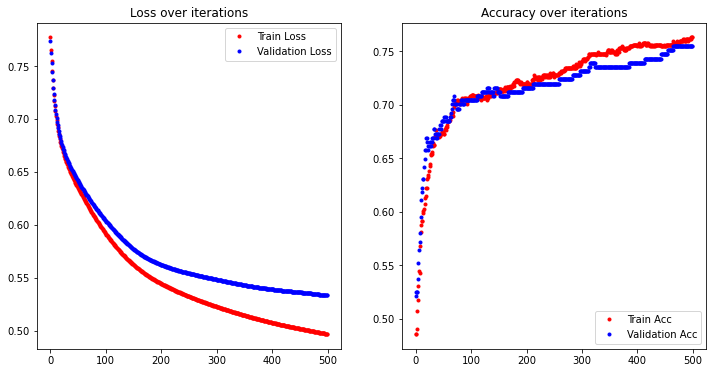

In [37]:
# Plot loss & accuracy functions
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.510
roc-auc is 0.816


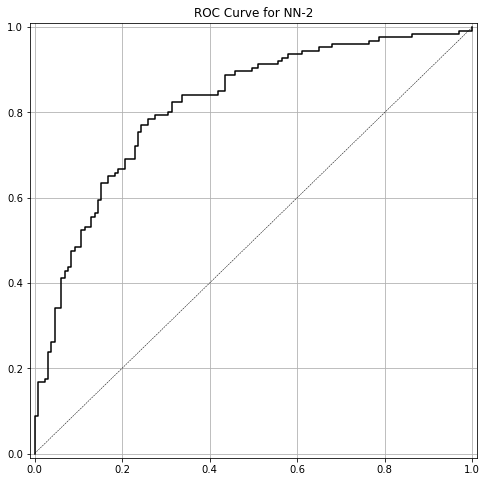

In [38]:
# Plot ROC curve
predict_x2=model_2.predict(X_test_s) 
y_pred_class_nn_2=np.argmax(predict_x2,axis=1)

y_pred_prob_nn_2 = model_2.predict(X_test_s)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test_c,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test_c,y_pred_prob_nn_2)))

plot_roc(y_test_c, y_pred_prob_nn_2, 'NN-2')

# Model with Multiple Hidden Layers & Different Activation Functions

In [39]:
# Define model
model_3 = Sequential()
model_3.add(Dense(12, input_shape=(10,), activation="relu"))
model_3.add(Dense(12, activation="relu"))
model_3.add(Dense(12, activation="sigmoid"))
model_3.add(Dense(1, activation="sigmoid"))

# Run model
model_3.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_3 = model_3.fit(X_train_s, y_train_c, validation_data=(X_test_s, y_test_c), epochs=500)

Epoch 1/500


/Users/lprichard/miniconda3/envs/a37_tf/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 0s 7ms/step - loss: 0.7304 - accuracy: 0.5042 - val_loss: 0.7357 - val_accuracy: 0.4903
Epoch 2/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7265 - accuracy: 0.5042 - val_loss: 0.7316 - val_accuracy: 0.4903
Epoch 3/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7231 - accuracy: 0.5042 - val_loss: 0.7280 - val_accuracy: 0.4903
Epoch 4/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7200 - accuracy: 0.5042 - val_loss: 0.7247 - val_accuracy: 0.4903
Epoch 5/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7173 - accuracy: 0.5042 - val_loss: 0.7218 - val_accuracy: 0.4903
Epoch 6/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7149 - accuracy: 0.5042 - val_loss: 0.7192 - val_accuracy: 0.4903
Epoch 7/500
19/19 [==============================] - 0s 2ms/step - loss: 0.7127 - accuracy: 0.5008 - val_loss: 0.7169 - val_accuracy: 0.4903
Epoch 8/500
19/19 [======

Epoch 59/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5142 - val_loss: 0.6946 - val_accuracy: 0.4981
Epoch 60/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5142 - val_loss: 0.6946 - val_accuracy: 0.4981
Epoch 61/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5175 - val_loss: 0.6945 - val_accuracy: 0.4981
Epoch 62/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5159 - val_loss: 0.6945 - val_accuracy: 0.4942
Epoch 63/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6944 - val_accuracy: 0.5019
Epoch 64/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5192 - val_loss: 0.6943 - val_accuracy: 0.5019
Epoch 65/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5125 - val_loss: 0.6943 - val_accuracy: 0.5019
Epoch 

19/19 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.6210 - val_loss: 0.6894 - val_accuracy: 0.6070
Epoch 174/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.6210 - val_loss: 0.6893 - val_accuracy: 0.6070
Epoch 175/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.6144 - val_loss: 0.6892 - val_accuracy: 0.6148
Epoch 176/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.6277 - val_loss: 0.6892 - val_accuracy: 0.6148
Epoch 177/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.6227 - val_loss: 0.6891 - val_accuracy: 0.6148
Epoch 178/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.6244 - val_loss: 0.6891 - val_accuracy: 0.6187
Epoch 179/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.6277 - val_loss: 0.6890 - val_accuracy: 0.6109
Epoch 180/500

19/19 [==============================] - 0s 2ms/step - loss: 0.6705 - accuracy: 0.7028 - val_loss: 0.6790 - val_accuracy: 0.6459
Epoch 288/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6703 - accuracy: 0.7062 - val_loss: 0.6788 - val_accuracy: 0.6459
Epoch 289/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.7062 - val_loss: 0.6787 - val_accuracy: 0.6459
Epoch 290/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6698 - accuracy: 0.7078 - val_loss: 0.6785 - val_accuracy: 0.6459
Epoch 291/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.7112 - val_loss: 0.6784 - val_accuracy: 0.6459
Epoch 292/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.7112 - val_loss: 0.6782 - val_accuracy: 0.6498
Epoch 293/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.7129 - val_loss: 0.6781 - val_accuracy: 0.6498
Epoch 294/500

19/19 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.7462 - val_loss: 0.6496 - val_accuracy: 0.6615
Epoch 402/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6295 - accuracy: 0.7479 - val_loss: 0.6492 - val_accuracy: 0.6615
Epoch 403/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6289 - accuracy: 0.7462 - val_loss: 0.6487 - val_accuracy: 0.6615
Epoch 404/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6284 - accuracy: 0.7446 - val_loss: 0.6483 - val_accuracy: 0.6615
Epoch 405/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6278 - accuracy: 0.7429 - val_loss: 0.6479 - val_accuracy: 0.6654
Epoch 406/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6272 - accuracy: 0.7446 - val_loss: 0.6475 - val_accuracy: 0.6654
Epoch 407/500
19/19 [==============================] - 0s 2ms/step - loss: 0.6267 - accuracy: 0.7412 - val_loss: 0.6471 - val_accuracy: 0.6654
Epoch 408/500

Text(0.5, 1.0, 'Accuracy over iterations')

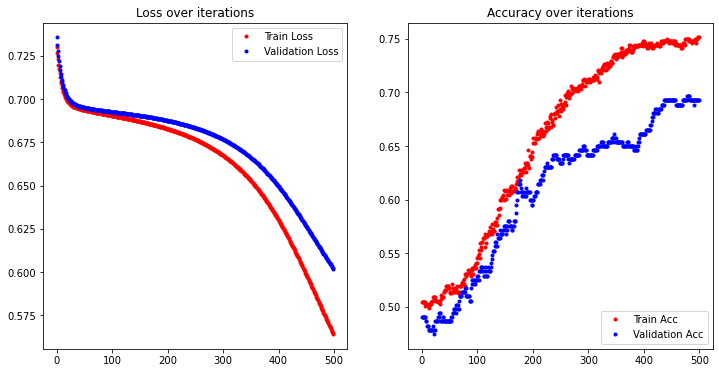

In [40]:
# Plot loss & accuracy functions
n = len(run_hist_3.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_3.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_3.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_3.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_3.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.510
roc-auc is 0.753


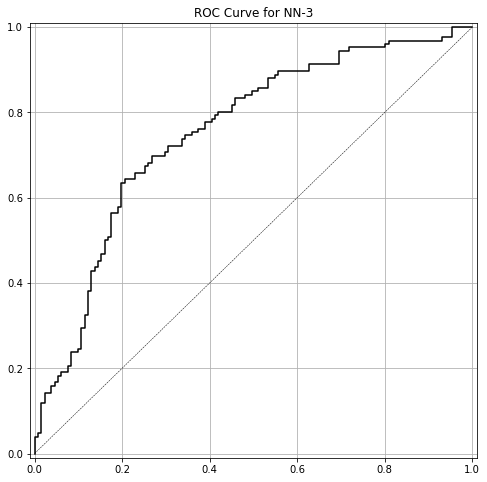

In [41]:
# Plot ROC Curve
predict_x3=model_3.predict(X_test_s) 
y_pred_class_nn_3=np.argmax(predict_x3,axis=1)

y_pred_prob_nn_3 = model_3.predict(X_test_s)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test_c,y_pred_class_nn_3)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test_c,y_pred_prob_nn_3)))

plot_roc(y_test_c, y_pred_prob_nn_3, 'NN-3')

# Clustering and Neural Net

In [42]:
# Start with 2 clusters then test params then increase after testing
km = KMeans(n_clusters=4, random_state=42)
km = km.fit(data[icols])

data['kmeans'] = km.predict(X)

In [43]:
# Get clustering values
(data[['abv-avg-eviction-rate','kmeans']]
 .groupby(['kmeans','abv-avg-eviction-rate'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans abv-avg-eviction-rate        
0      0                         111
       1                          53
1      0                         132
       1                         202
2      0                         163
       1                         165
3      0                          22
       1                           8

**Find Optimum Number of Clusters**

In [44]:
# Create and fit a range of models
km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data[icols])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

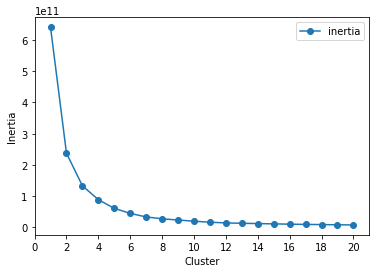

In [45]:
# Plot different intertia values for different cluster values
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

**Run Neural Net with Clustering**

In [46]:
# Set data arrays as discrete version of target variable
X_c = data[icols+['kmeans']]
y_c = data['abv-avg-eviction-rate']

# Split data into test and training sets using classification variable
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.3, random_state=72018)

# Normalize the data
s = StandardScaler()
X_train_cs = s.fit_transform(X_train_c)
X_test_cs = s.transform(X_test_c)

In [50]:
# Define model
model_4 = Sequential()
model_4.add(Dense(12, input_shape=(11,), activation="relu"))
model_4.add(Dense(12, activation="relu"))
model_4.add(Dense(1, activation="sigmoid"))

# Run model
model_4.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_4 = model_4.fit(X_train_cs, y_train_c, validation_data=(X_test_cs, y_test_c), epochs=100)

/Users/lprichard/miniconda3/envs/a37_tf/lib/python3.7/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6977 - accuracy: 0.4841 - val_loss: 0.6942 - val_accuracy: 0.4942
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5042 - val_loss: 0.6895 - val_accuracy: 0.5175
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5326 - val_loss: 0.6852 - val_accuracy: 0.5214
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5459 - val_loss: 0.6812 - val_accuracy: 0.5214
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6782 - accuracy: 0.5609 - val_loss: 0.6776 - val_accuracy: 0.5292
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5810 - val_loss: 0.6743 - val_accuracy: 0.5447
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.6708 - accuracy: 0.5860 - val_loss: 0.6711 - val_accuracy: 0.5370
Epoch 8/100
1

Epoch 59/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5810 - accuracy: 0.7212 - val_loss: 0.5851 - val_accuracy: 0.7471
Epoch 60/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.7179 - val_loss: 0.5840 - val_accuracy: 0.7510
Epoch 61/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5788 - accuracy: 0.7195 - val_loss: 0.5829 - val_accuracy: 0.7549
Epoch 62/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5776 - accuracy: 0.7195 - val_loss: 0.5818 - val_accuracy: 0.7510
Epoch 63/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.7195 - val_loss: 0.5807 - val_accuracy: 0.7510
Epoch 64/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.7195 - val_loss: 0.5796 - val_accuracy: 0.7549
Epoch 65/100
19/19 [==============================] - 0s 2ms/step - loss: 0.5742 - accuracy: 0.7195 - val_loss: 0.5785 - val_accuracy: 0.7549
Epoch 

Text(0.5, 1.0, 'Accuracy over iterations')

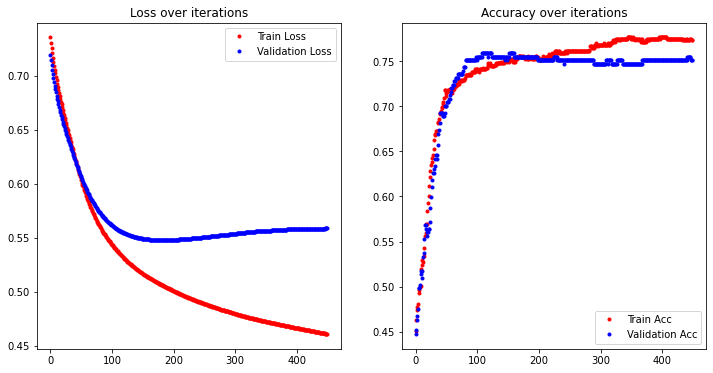

In [48]:
# Plot loss & accuracy functions
n = len(run_hist_4.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_4.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_4.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_4.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_4.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.510
roc-auc is 0.818


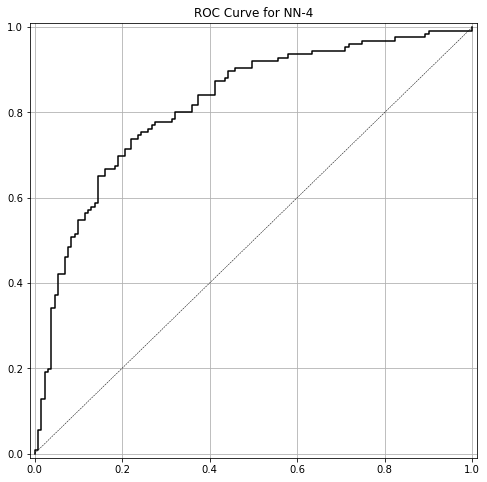

In [51]:
# Plot ROC curve
predict_x4=model_4.predict(X_test_cs) 
y_pred_class_nn_4=np.argmax(predict_x4,axis=1)

y_pred_prob_nn_4 = model_4.predict(X_test_cs)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test_c,y_pred_class_nn_4)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test_c,y_pred_prob_nn_4)))

plot_roc(y_test_c, y_pred_prob_nn_4, 'NN-4')